# CS5242 Group56 Project - Title Generation of Newspaper Articles

## Group Members
+ A0080504R FENG Weidong​
+ A0237337B YAN Yibo

## GitHub Repository with all the requisite files and scripts
https://github.com/fwd370/nndlnews

## 1.  Introduction
### 1.1 Motivation
We live in an age of information overload. There are hundreds (if not thousands) of news sites actively publishing articles everyday. Being bombarded with information makes it challenging to identify what is important. However, we want to exploit available information to keep up with things happening around us. Our proposed solution is to structure our access to information in a hierarchical way. We believe this starts with abstracting and summarizing the topics of online news articles. Staying aware of the topic trends and sentiment over time will facilitate development of our judgment and awareness of issues and the society at large over time. ​

According to a survey by Reuters Institute, in 2021, 83% of Singaporeans access their news via 1 online sources. We believe this proportion will increase over time, therefore we propose to focus only on online news sites. 

### 1.2 Objective
+ compare the performance of VRNN, GRU, LSTM in newspaper title prediction
+ evaluate the effect of data processing for best model
+ evaluate the effect of data amount for best model

In [2]:
import pandas as pd
import numpy as np
import re
import contractions
import json
import nltk
nltk.download('punkt')
import random
import time
import datetime
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math
from rouge import Rouge
import argparse
import json
import wandb

## 2.  Methodology
### 2.1 Data Collection
we first scraped 800 newspapers from CNA website and 1400 articles from the Today website. An example showing the scraping of 35 URLs is demonstrated below

In [3]:
# packages needed for DATA COLLECTION
# %reset -f
from selenium import webdriver
import os
import csv
import datetime
import hashlib
import random
import time
import requests
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.common.action_chains import ActionChains

from webdriver_manager.chrome import ChromeDriverManager

def initUrlFile():
    f = open('./today_STATIC_URL.csv', 'w')
    writer = csv.writer(f)
    writer.writerow(("id","pKey","datetime","url","title","collected"))
    f.close()
    
def openUrlFile(paper,header=False,visitedOnly=False):
    '''
    Helper function to help read all URLs scraped so far. 
    
    Parameters:
    paper: takes in a paper name which will be used to generate filname that
            takes in a local csv file containing all urls scraped thus far
    header: If True, will return a list of all scraped urls with the Header intact. Else header omitted
    
    Returns:
    lst: A python-list of all STATIC URLs scrapped from website main page
    visited: A python-dict of all urls in this set (for further scraping)
    '''
    assert paper == "cna" or paper == "today"
    filename=f'{paper}_STATIC_URL.csv'
    f = open('./'+filename, 'r')
    reader = csv.reader(f)
    lst = [list(row) for row in reader]
    f.close()
    if not header:
        lst = lst[1:]
    visited = {}
    for art in lst:
        visited[art[3]]=1
    if visitedOnly:
        return len(lst), visited
    return lst, visited

def appendToUrlFile(stack,paper):
    assert paper == "cna" or paper == "today"
    filename=f'{paper}_STATIC_URL.csv'
    f = open(f'./{filename}', 'a')
    writer = csv.writer(f)
    for i, tup in enumerate(stack):
        writer.writerow((
            i,
            hashlib.md5(tup[2].encode()).hexdigest(),
            tup[1],
            tup[2],
            tup[3],
            0)
        )
    f.close()
    print(f"Appended {i+1} newly scraped URLs to file")
    return

initUrlFile()
static_stack=[]
aCount,visited = openUrlFile("today",visitedOnly=True)
WEB_TO_CRAWL = "https://www.todayonline.com/singapore"
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get(WEB_TO_CRAWL)    #load target webpage
time.sleep(7)

count = 0

while (count < 35): 
    staticArticlesOnMainPage = driver.find_elements(By.CSS_SELECTOR, ".list-object__heading-link")
    if count == 0:
        print(len(staticArticlesOnMainPage))
    for ele in staticArticlesOnMainPage:

        if ele.get_attribute('href') not in visited:
            visited[ele.get_attribute('href')] = 1
            static_stack.append((
                aCount-1+count,
                datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
                ele.get_attribute('href'),
                ele.get_property('text').strip())
            )
            count += 1
            if count % 20 == 0:
                print(f"Scraped {count} urls so far")

    '''
    For Load more content button:
    '''
    # Scroll to the end of the page.
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)
    # Select the Load More Button
    loadMoreButton = driver.find_element(By.CSS_SELECTOR, ".button")
    time.sleep(1)
    #Click the Load More button and give the page some time to render.
    loadMoreButton.click()
    time.sleep(5)
driver.close()

appendToUrlFile(static_stack,"today")

35
Scraped 20 urls so far
Appended 35 newly scraped URLs to file


Using the URLs we collected, we then collect the articles and the titles using the functions provided below:

In [ ]:
## Init text dump file
def initTextDumpFile():
    with open('./today_TEXT_DUMP.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(("id","pKey","author","publishDate","updateDate","topics","text","relevantUrl"))
        f.close()
        #f.writelines(text_collection)
    return

def appendRowToTextDump(writer,idx,pKey,author,publishDate,updateDate,topics,text,relatedURL):
    publishDate = datetime.datetime.strptime(publishDate,'%B %d, %Y').strftime("%m/%d/%Y, %H:%M:%S")
    updateDate = datetime.datetime.strptime(updateDate,'%B %d, %Y').strftime("%m/%d/%Y, %H:%M:%S")
    writer.writerow((idx,pKey,author,publishDate,updateDate,topics,text,relatedURL))
    return

initTextDumpFile()
dynamic_stack,visited = openUrlFile()

## Crawl the URLs
text_collection = []
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

f = open('./today_TEXT_DUMP.csv', 'a')
writer = csv.writer(f)
count = 0
for i,tup in enumerate(dynamic_stack):
    text_collection = []
    if tup[5] == '0':
        WEB_TO_CRAWL = tup[3]
        time.sleep(random.randint(1,3))
        driver.get(WEB_TO_CRAWL)    #load target webpage
        time.sleep(5)
        
        try:
            author = driver.find_element(By.CSS_SELECTOR, ".link.link--author-profile").get_attribute("innerText").strip()
        except:
            print(i, "No Author Found")
            author = None
        try:
            topics = [ele.get_attribute("innerText").strip() for ele in driver.find_elements(By.CSS_SELECTOR, ".link.link--trending")]
        except:
            print(i, "No Topics Found")
            topics = None
        try:
            related = [(ele.get_attribute("innerText").strip(),ele.get_attribute("href").split("?")[0]) for ele in driver.find_elements(By.CSS_SELECTOR,".read-also-box .h4__link")]            
        except:
            print(i, "No Related Articles Found")
            related = None
        dateType = [ele.get_attribute("innerText").split(" ",1) for ele in driver.find_elements(By.CSS_SELECTOR, ".article__row")]
        publishDate = None
        updatedate = None
        for d in dateType:
            if d[0][0].lower()=="p":
                publishDate = d[1]
            if d[0][0].lower()=="u":
                updateDate = d[1] 
        paras = driver.find_elements(By.CSS_SELECTOR, '.text .text-long p , p+ul>li')   #find text elements. In http, text elements commonly have 'p' as tag name. Similarly, images commonly have 'img' as tag name.
        for para in paras:
            text = para.get_attribute("innerText")  #get text content from the element object
            text = text.replace("\xa0"," ").strip()
            text_collection.append(text + '\n')
        appendRowToTextDump(writer,tup[0], tup[1],author, publishDate, updateDate, topics, text_collection,related)
        
        dynamic_stack[i][5] = "1"
        count += 1
        if count%20 ==0:
            print(f'{count} articles scrapped and saved')
        
print(f'{count} articles scrapped and saved')
            
driver.close()
f.close()


### 2.2 Read in Data
Upon completion of data collection, we started to read in data. We initially started the training using the 800 articles scrapped from CNA. Our original intention was to feed the entire newspaper articles into the RNN and train it to produce the title of the article.

In [6]:
import nltk
def read_data(file='Data.csv'):
    word2index={}
    index2word={}
    data = pd.read_csv('data/'+file)
    summarys = []
    contents = []
    for i, row in data.iterrows():
        content = []
        summary = []
        for word in nltk.word_tokenize(str(row['Content'])):
            if word not in word2index:
                word2index[word] = len(word2index)
            content.append(word2index[word])
        for word in nltk.word_tokenize(
                str(row['Title']) + str(row['Subtitle'])):
            if word not in word2index:
                word2index[word] = len(word2index)
            summary.append(word2index[word])
        summarys.append(summary)
        contents.append(content)
    word2index['PAD'] = len(word2index)
    word2index['BOS'] = len(word2index)
    word2index['EOS'] = len(word2index)
    index2word = {v: k for k, v in word2index.items()}
    return contents, summarys, word2index, index2word
contents, summarys, word2index, index2word = read_data()
print(f"Original Vocabulary size of the data: {len(word2index)}")

Original Vocabulary size of the data: 30372


### 2.3 Exploratory Data Analysis and Text Processing
Our original trials with feeding the entire articles and expecting the model to be able to predict the title from the entire article proved inefficient. It generally took more time to train and did not produce the best results.

We thus decided to perform exploratory data analysis on the articles and see whether we can reduce the dimensionality of our inputs to enhance the training of the model.

We hypothesize that Newspapers often contain the main topics in the first few sentences of the articles, as we tried to analyse the % of vocabulary of the title that is contained in the first n (1 to 10) sentences of the articles.

From the output prints in the next cell, we can observe 1) The % Vocabulary Intersection between the TITLE and the ARTICLE decreases as a larger number of first n sentences in the article is considered

Initially, the length of dictionary is 30,372. After further data processing (tokenization, removal of punctuation, converting all numerics to "N"), we realised we can reduce the input dimension to 8,382 (almost 4 times less!) if we only considered the first 3 sentences.

In [8]:
# code showing text processing
import pandas as pd
import numpy as np
import re
import contractions
import json
import nltk
nltk.download('punkt')

class Vocabulary:
    def __init__(self):
        self.word2index = {"<SOS>":0,"<EOS>":1,"<UNK>":2,"<PAD>":3}
        self.word2count = {}
        self.index2word = {0:"<SOS>",1:"<EOS>",2:"<UNK>",3:"<PAD>"}
        self.n_words = 4 #Start count with "SOS", "EOS", UNK, PAD
    def addToVocab(self, sentence: str):
        for word in sentence.split(" "):
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.n_words+= 1
                self.word2count[word] = 1
            else:
                self.word2count[word] += 1
    def convertSentenceToIndex(self, sentence: str):
        idxs = [self.word2index[word] for word in sentence.split(" ")]
        idxs.append(EOS_token)

def processString(text: str): 
    text = re.sub("\\\\n","",text)              # Remove Line breaks in the article 
    text = re.sub("SINGAPORE","",text)              # Unique processing for Today articles 
    text = contractions.fix(text)                   # Replaces apostrophes with full word to reduce dimensionality 
    text = re.sub(r"([.!?])",r" \1", text) 
    text = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", text) 
    text = text.lower().strip() 
    text = re.sub(r"[0-9]+","N",text) 
    return text

def readDataAndVocab(n_truncate: int):
    
    MAX_LENGTH = 300 # We limit the amount of words being fed into the model
    
    
    print("Retrieving Data..")
    vocab = Vocabulary()
    first_vocab = Vocabulary()
    title_vocab = Vocabulary()
    other_vocab = Vocabulary()
    
    data = []
    df = pd.read_csv("data/rawData.csv")
    print(f"Total number of data rows (articles): {len(df.index)}")
    
    for index, row in df.iterrows():
        text = row["Content"]
        title = processString(row["Title"])

        sent_list=nltk.tokenize.sent_tokenize(text)
        num_of_sentences = len(sent_list)
        
        # creating Vocab of title words only
        title_vocab.addToVocab(title)
        
        # We hypothesize that only the first n_truncate sentences of the news article affects the title
        # we only keep the first 3, and discard the rest as noise.
        end_boundary = n_truncate if n_truncate < num_of_sentences else num_of_sentences
        first_sentences = sent_list[0:end_boundary]
        other_sentences = sent_list[end_boundary:]
        
        # creating Vocab of 4th sentence onwards
        other_vocab.addToVocab(processString(''.join(other_sentences)))
        

        text = processString(''.join(first_sentences))
        
        # creating Vocab of first 3 sentences only
        first_vocab.addToVocab(text)
        
        # Appending data and vocab for 3 sentences only
        if (len(text.split(' ')) < MAX_LENGTH and len(title.split(' ')) < MAX_LENGTH):
            data.append([text, title])
            vocab.addToVocab(text)
            vocab.addToVocab(title)
    return data, vocab, title_vocab, other_vocab, first_vocab

for n in range(1,10):
    data, VOCAB_MODEL, TITLE_VOCAB, OTHER_VOCAB, FIRST_VOCAB = readDataAndVocab(n)
    count=len(set(TITLE_VOCAB.word2index.keys()).intersection(FIRST_VOCAB.word2index.keys()))
    o_count = len(set(TITLE_VOCAB.word2index.keys()).intersection(OTHER_VOCAB.word2index.keys()))
    print(f"FIRST_{n} VOCAB INTERSECTION SIZE: {count}")
    print(f"% of TITLE & FIRST_{n} Sentence overlap = {count/len(set(TITLE_VOCAB.word2index.keys()).union(FIRST_VOCAB.word2index.keys())):.3f}")
    print(f"% of TITLE & OTHER ({n}-th onward) Sentence overlap = {o_count/len(set(TITLE_VOCAB.word2index.keys()).union(OTHER_VOCAB.word2index.keys())):.3f}")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fengweidong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Retrieving Data..
Total number of data rows (articles): 806
FIRST_1 VOCAB INTERSECTION SIZE: 2654
% of TITLE & FIRST_1 Sentence overlap = 0.514
% of TITLE & OTHER (1-th onward) Sentence overlap = 0.151
Retrieving Data..
Total number of data rows (articles): 806
FIRST_2 VOCAB INTERSECTION SIZE: 2924
% of TITLE & FIRST_2 Sentence overlap = 0.409
% of TITLE & OTHER (2-th onward) Sentence overlap = 0.152
Retrieving Data..
Total number of data rows (articles): 806
FIRST_3 VOCAB INTERSECTION SIZE: 3025
% of TITLE & FIRST_3 Sentence overlap = 0.361
% of TITLE & OTHER (3-th onward) Sentence overlap = 0.154
Retrieving Data..
Total number of data rows (articles): 806
FIRST_4 VOCAB INTERSECTION SIZE: 3087
% of TITLE & FIRST_4 Sentence overlap = 0.329
% of TITLE & OTHER (4-th onward) Sentence overlap = 0.155
Retrieving Data..
Total number of data rows (articles): 806
FIRST_5 VOCAB INTERSECTION SIZE: 3138
% of TITLE & FIRST_5 Sentence overlap = 0.305
% of TITLE & OTHER (5-th onward) Sentence overla

### 2.4 Model Selection & Architecture Design
We chose **vanilla RNN** as our baseline model as it is designed for sequential data. 


An RNN works like this; First words get transformed into machine-readable vectors. Then the RNN processes the sequence of vectors one by one.
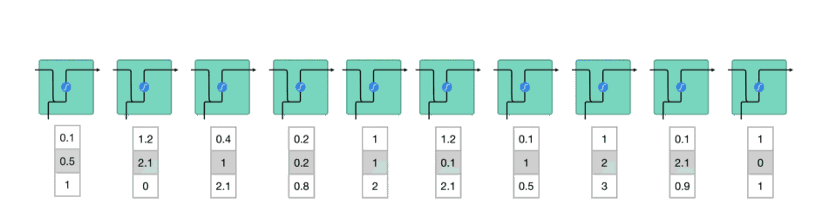

While processing, it passes the previous hidden state to the next step of the sequence. The hidden state acts as the neural networks memory. It holds information on previous data the network has seen before.
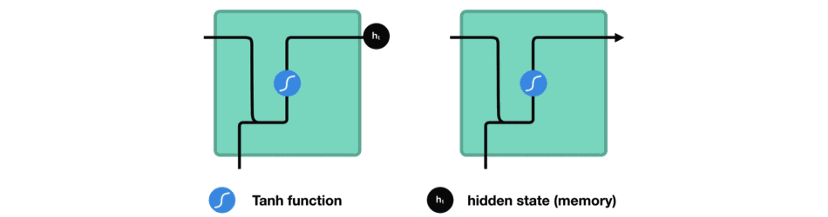

Inside a cell of the RNN, first, the input and previous hidden state are combined to form a vector. That vector now has information on the current input and previous inputs. The vector goes through the tanh activation, and the output is the new hidden state, or the memory of the network.

An **LSTM** has a similar control flow as a recurrent neural network. It processes data passing on information as it propagates forward. The differences are the operations within the LSTM’s cells. These operations are used to allow the LSTM to keep or forget information. Therefore, we used LSTM as our improved model 1.
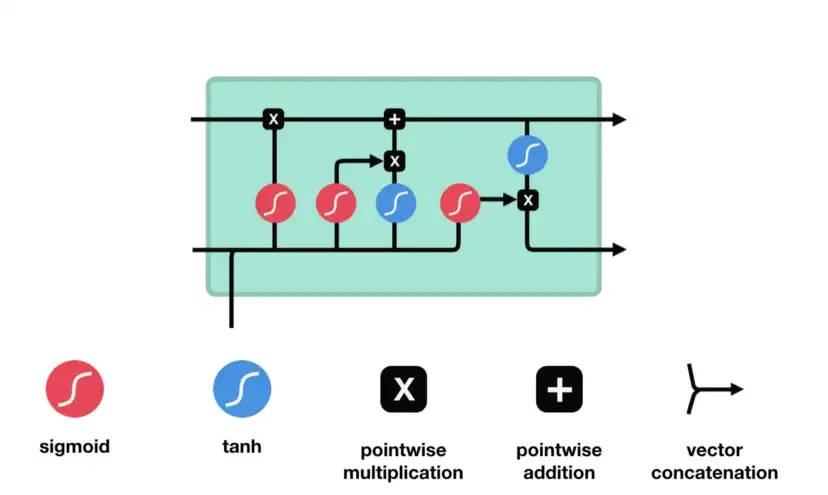

Furthermore, **GRU** is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate. Therefore, GRU can be used as our improved model 2.
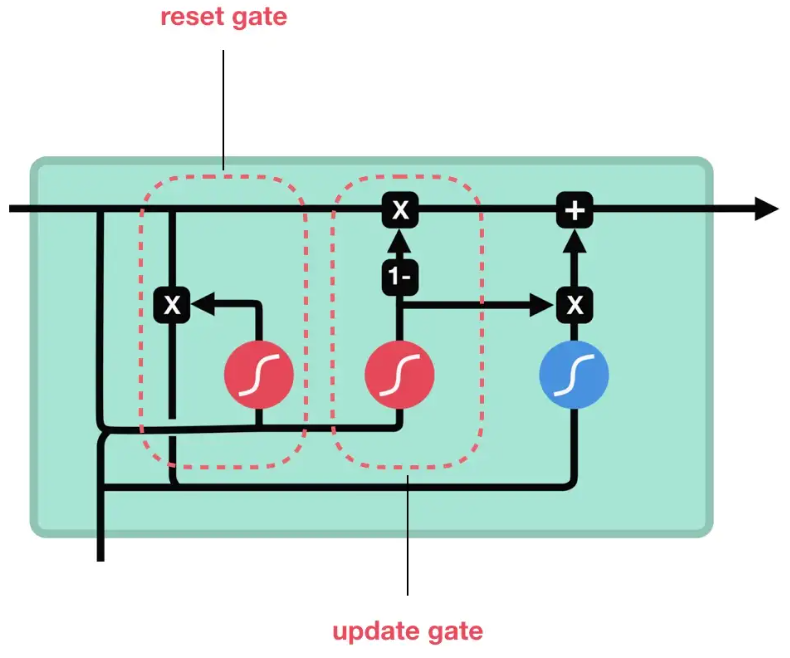

In general, the architecture for title summarization would be encoder-decoder architecture.
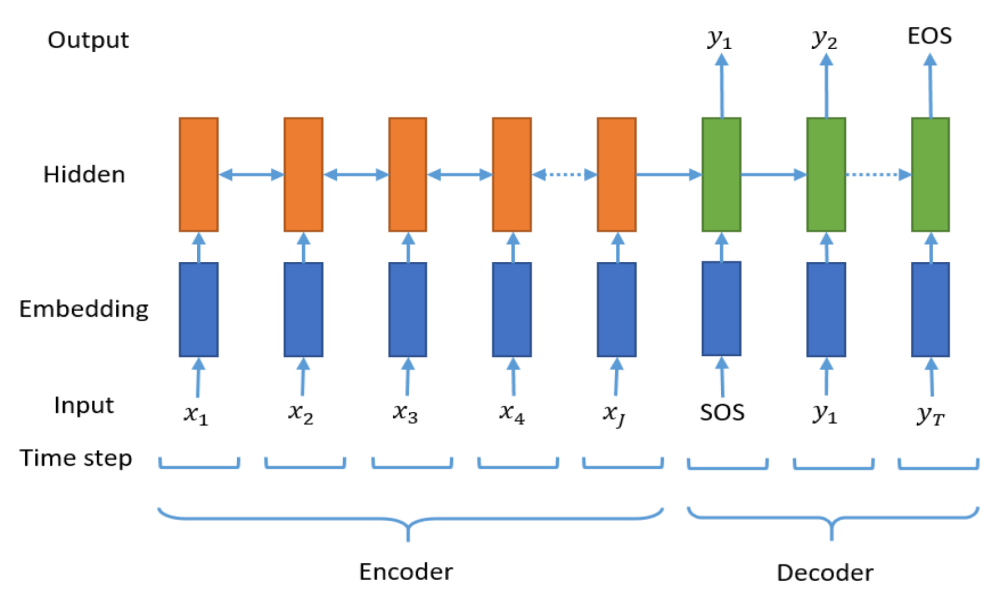

### 2.5 Performance Metrics
#### 2.5.1 Perplexity
Though not frequently used, **perplexity** is still used to evaluate some automatic summaries. Perplexity aims to measure **how likely a sentence is**, with a higher perplexity indicating that the sentence is less likely. This measure is mostly used for abstractive summarization since it also involves having to create new sentences.

In our project, we will use the exponential function to calculate perplexity from cross entropy loss.

#### 2.5.2 ROUGE(S)
One of the most widely used metrics is the Recall-Oriented Understudy for gisting Evaluation, commonly known as **ROGUE**; this metric was elaborated especifically for evaluating summaries. In reality, ROGUE various different sub-metrics that are used, with the original paper introducing four of these: ROUGE-N, ROUGE-L, ROUGE-W, and ROUGE-S. The specifics of these are quite different, but they all operate under the same basic logic: we compare a proposed summary sentence with a reference summary and calculate how “good” the proposed summary is based on some similarity metric with the reference one. Another similarity between these metrics is that a higher ROGUE score indicates a “better” summary.

In our project, we will use the following metrics:
+ **ROUGE-N**: measures the **number of matching n-grams** between the model-generated text and a human-produced reference.
    + **ROUGE-1**: unigram overlap
    + **ROUGE-2**: bigram overlap
+ **ROUGE-L**: measures **longest matching sequence** of words using LCS (longest common subsequence). An advantage of using LCS is that it does not require consecutive matches but in-sequence matches that reflect sentence level word order. Since it automatically includes longest in-sequence common n-grams, you don’t need a predefined n-gram length.

## 3.  Result & Analysis
### 3.1 Baseline Model vs Improved Models
We first built up the encoder and decoder classes for them, and subsequently implemented the Seq2Seq classes as the architecture for title generation.

In [ ]:
# RNN encoder and decoder classes
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim).to(device)
        self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout=dropout).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)

        return outputs, hidden

class RNNDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim).to(device)
        self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout=dropout).to(device)
        self.fc_out = nn.Linear(hid_dim, output_dim).to(device)
        self.dropout = nn.Dropout(dropout).to(device)
    
    def forward(self, input, hidden):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(0))

        return prediction, hidden

# RNN Seq2Seq class
class RNNSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size,
                              trg_vocab_size).to(self.device)
        output, hidden = self.encoder(src)

        input = trg[0, :]

        for t in range(1, trg_len):
            # Get the output from decoder
            output, hidden = self.decoder(input, hidden)

            # Repalce the output at time t
            outputs[t] = output

            # Teacher Forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the output with maximal probability
            top1 = output.argmax(1)

            # The new one as the input of next step
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
# LSTM encoder and decoder classes
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim).to(device)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)

        return hidden, cell
    
class LSTMDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim).to(device)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout).to(device)
        self.fc_out = nn.Linear(hid_dim, output_dim).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, input, hidden,cell):
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))

        return prediction, hidden, cell
    
# LSTM Seq2Seq class
class LSTMSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size,
                              trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)

        input = trg[0, :]

        for t in range(1, trg_len):
            # Get the output from decoder
            output, hidden, cell = self.decoder(input, hidden, cell)

            # Repalce the output at time t
            outputs[t] = output

            # Teacher Forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the output with maximal probability
            top1 = output.argmax(1)

            # The new one as the input of next step
            input = trg[t] if teacher_force else top1

        return outputs


In [ ]:
# GRU encoder and decoder classes
class GRUEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim).to(device)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, src):

        embedded = self.dropout(self.embedding(src))
        outputs,  hidden = self.rnn(embedded)

        return outputs, hidden
    
class GRUDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim).to(device)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout).to(device)
        self.fc_out = nn.Linear(hid_dim, output_dim).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, input, hidden):

        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(0))

        return prediction, hidden
    
# GRU Seq2Seq class
class GRUSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size,
                              trg_vocab_size).to(self.device)
        output, hidden = self.encoder(src)

        input = trg[0, :]

        for t in range(1, trg_len):

            # Get the output from decoder
            output, hidden = self.decoder(input, hidden)

            # Repalce the output at time t
            outputs[t] = output

            # Teacher Forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the output with maximal probability
            top1 = output.argmax(1)

            # The new one as the input of next step
            input = trg[t] if teacher_force else top1

        return outputs

We defined some helper functions here.

In [ ]:
# helper functions during training
class CuDataset(Dataset):
    def __init__(self, sources, targets):
        self.sources = sources
        self.targets = targets

    def __getitem__(self, idx):
        idx = int(idx)
        item = {}
        item['src'] = torch.tensor(self.sources[idx])
        item['tgt'] = torch.tensor(self.targets[idx])
        return item

    def __len__(self):
        return len(self.sources)
    
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

def pad_data(contents,summarys,word2index):
    max_src = min(max(map(len, contents)), 512)
    max_tgt = min(max(map(len, summarys)), 128)
    sources = []
    targets = []
    for i in contents:
        if len(i) < max_src:
            i += [word2index['PAD']] * (max_src - len(i))
        sources.append(i[:max_src])

    max_tgt += 2
    for i in summarys:
        if len(i) < max_tgt:
            i = [word2index['BOS']] + i + [word2index['EOS']]
            i += [word2index['PAD']] * (max_src - len(i))
        targets.append(i[:max_tgt])
    return sources, targets

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch['src'].transpose(0, 1).to(device)
        trg = batch['tgt'].transpose(0, 1).to(device)

        optimizer.zero_grad()

        input_tgt = trg[:-1].to(device)
        label_tgt = trg[1:].to(device)

        output = model(src, input_tgt)

        output_dim = output.shape[-1]

        output = output.view(-1, output_dim)
        trg = label_tgt.contiguous().view(-1)

        loss = criterion(output, trg)
        
        if i%50==0:
            print(f'[Step] Train Loss: {loss:.3f} | Train PPL: {math.exp(loss):7.3f}')

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

@torch.no_grad()
def evaluate(model, dataloader, criterion):

    model.eval()

    epoch_loss = 0
    dataloader
    with torch.no_grad():

        for i, batch in enumerate(dataloader):

            src = batch['src'].transpose(0, 1).to(device)
            trg = batch['tgt'].transpose(0, 1).to(device)

            input_tgt = trg[:-1]
            label_tgt = trg[1:]
            output = model(src, input_tgt, 0)  #turn off teacher forcing

            output_dim = output.shape[-1]

            output = output.view(-1, output_dim)
            label_tgt = label_tgt.contiguous().view(-1)

            loss = criterion(output, label_tgt)

            print(
                f'[Step] Train Loss: {loss:.3f} | Train PPL: {math.exp(loss):7.3f}'
            )

            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

# helper functions for generation and evaluation
@torch.no_grad()
def generate(model, dataloader, max_len=50):

    model.eval()

    all_output = []

    for batch in dataloader:

        src = batch['src'].transpose(0, 1)
        trg = batch['tgt'].transpose(0, 1)

        batch_size = trg.shape[1]

        output, hidden = model.encoder(src)

        trg_indexes = [word2index['BOS']] * batch_size

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        outputs = torch.zeros(max_len, batch_size, dtype=torch.int)

        input = trg_tensor[0, :]

        for i in range(max_len):
            output, hidden = model.decoder(input, hidden)

            pred_token = output.argmax(1)
            outputs[i] = pred_token
            input = torch.LongTensor(pred_token).to(device)

        all_output.append(outputs.transpose(0, 1).numpy())

    return np.concatenate(all_output, axis=0)    

def compute_rouge(decoded_preds, decoded_labels):
    rouge = Rouge()
    scores = []
    for i, j in zip(decoded_preds, decoded_labels):
        score = rouge.get_scores(' '.join(i), ' '.join(j))
        scores.append([
            score[0]['rouge-1']['f'], score[0]['rouge-2']['f'],
            score[0]['rouge-l']['f']
        ])
    rouge1 = np.mean([i[0] for i in scores])
    rouge2 = np.mean([i[1] for i in scores])
    rougel = np.mean([i[2] for i in scores])
    result = {
        "rouge1": round(rouge1, 4),
        "rouge2": round(rouge2, 4),
        "rouge-l": round(rougel, 4)
    }
    return result

We now started to train the models using the pre-defined classes and functions above.

In [ ]:
# RNN training code
def init_model_RNN(word2index, device, HID_DIM, N_LAYERS, ENC_EMB_DIM, DEC_EMB_DIM, ENC_DROPOUT, DEC_DROPOUT):
    INPUT_DIM = len(word2index)
    OUTPUT_DIM = len(word2index)

    enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = RNNSeq2Seq(enc, dec, device).to(device)
    return model



In [ ]:
# LSTM training code
def init_model_LSTM(word2index, device,HID_DIM,N_LAYERS,ENC_EMB_DIM,DEC_EMB_DIM,ENC_DROPOUT,DEC_DROPOUT):
    INPUT_DIM = len(word2index)
    OUTPUT_DIM = len(word2index)

    enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = LSTMSeq2Seq(enc, dec, device).to(device)
    return model



In [ ]:
# GRU training code
def init_model_GRU(word2index,device,HID_DIM,N_LAYERS,ENC_EMB_DIM,DEC_EMB_DIM,ENC_DROPOUT,DEC_DROPOUT):
    INPUT_DIM = len(word2index)
    OUTPUT_DIM = len(word2index)

    enc = GRUEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = GRUDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

    model = GRUSeq2Seq(enc, dec, device).to(device)
    return model



## 4. Analysis of Results

We run all three models (under 3 different conditions) with 42 different sets of hyperparameters in a grid search format. This resulted in 378 $ (3\times3\times42 = 378) $ runs for us to able to compare the results. All runs were tracked and synced to the cloud using the wandb (Weights and Biases) API. The full details of the runs have been broken down below:

**Conditions:**
+ **Baseline**: Feed entire article into model to generate Title
+ **Data PreProcessed**: 800 articles & Tokenize, Convert Numerics to "N", Use only first 3 sentences
+ **Full Data PreProcessed**: 2200 articles & Tokenize, Convert Numerics to "N", Use only first 3 sentences

| Type | Conditions | No. of Runs |
| --- | --- | --- |
| VRNN | Baseline | 42 |
| VRNN | Data PreProcessed | 42 |
| VRNN  | Full Data PreProcessed | 42 |
| GRU | Baseline | 42 |
| GRU | Data PreProcessed | 42 |
| GRU | Full Data PreProcessed | 42 |
| LSTM | Baseline | 42 |
| LSTM | Data PreProcessed | 42 |
| LSTM | Full Data PreProcessed | 42 |
| **Total** || **378** |

### 4.2 Analysis of Model Performance

<div>
<img src="ValidPPLvsClassTagAvgV2.png" alt="chartAvg" style="width: 500px;"/>
<img src="BestOfTagValidPPL.png" alt="chartBest" style="width: 500px;"/>
</div>


We compared the 9 different combination of (Model x Condition) using both the Average (of 42 runs) Performance and Best (1 run) Performance case.  

On the left we have the average validation perplexity of the 42 runs, and on the right plot the best validation perplexity for each of the combination's runs.  

**We observe that in both the Average and the Best case, the performance of the models were consistent.** In order of Validation Perplexity, we have (from Best to Worst model):   

**GRU_PP >> LSTM_PP >> VRNN_PP >> LSTM_FULL >> GRU_FULL >> VRNN_FULL >> LSTM >> GRU >> VRNN**

### 4.2.1 Model Performance - PreProcessed data vs. Non-PreProcessed data

**From the two charts, it is clear that there is a big gap in performance between the PreProcessed (PP) and non-PP data. On the other hand, the models trained on the smaller PP dataset produced better validation compared to the models trained for the larger PP datased**

We hypothesize that the in a simple language model, data PP constitutes a very significant contribution to performance because there is a lack of feature processing (in other worse dimension reduction) capability by the model. the significant reduction of the input dimensionality greatly enhances the performance of our model.  

On the other hand, the reason that the model performs better (in validation) for the smaller PP dataset could be due to the inherent differences between the datasets. The larger dataset consists of newspaper articles and titles coming from 2 different news websites, whereas the smaller dataset only containes articles and titles from 1 single website.

### 4.2.2 Model Performance - RNN Complexity

**Another interesting point to note is that the three types of RNNs generally performs better with the complexity (i.e. LSTM >> GRU >> VRNN), except in the case of the smaller PP dataset case.**

We hypothesize that this is because greater complexity typically allows the model to generalize better. But when only a small dataset is available, a simpler model might be better performing because not all the complexities in the data will appear during training to and be updated in the weights.

### 4.2.3 Model Performance - Hyperparameters

We also compared the effects of different hyperparameters on 2 best models (GRU_PP & LSTM_PP).

#### LSTM_PP Model



We observe that for the LSTM_PP Model, the greater the Batch Size, the higher the final training perplexity and therefore, a correspondingly lower Validation Perplexity. 

We believe that the **exact opposite trend in the Training and Validation perplexities suggest that the model is complex enough and is therefore overfitting on the training data set**

We also note that the validation perplexity improves with the batch size used. This runs contrary to the well known rule of thumb that too large of a batch size will lead to poor generalization.

Our hypothesis is that with larger batch sizes, **some of the noise associated with smaller batches is removed from the training update process. This explains why the larger batch size seem to produce models that generalize better.**

<div>
<img src="TrainPPLvsBSLSTM.png" alt="chartLSTMbsT" style="width: 500px;"/>
<img src="ValidPPLvsBSLSTM.png" alt="chartLSTMbsV" style="width: 500px;"/>
</div>

We also observe that Training Perplexity has inverse relationship with the hidden dimension. A lower hidden dimension reults in higher training perplexity and lower validation perplexity.

This is in line with our above conclusion that the **RNN models we have are significantly complex enough to overfit on the training dataset. This is why the models with the lowest hidden dimensions seem to generalise the best.**

<div>
<img src="TrainPPLvsBSLSTM.png" alt="chartLSTMHidDimT" style="width: 500px;"/>
<img src="ValidPPLvsBSLSTM.png" alt="chartLSTMHidDimV" style="width: 500px;"/>
</div>

#### GRU_PP Model

We observe a similar trend for the GRU_PP model. The key difference between the GRU and the LSTM is that the Longer-Term memory capabilities of the LSTM allows it to reduce overfitting to some extent. **We can observe this by observe below that the increase in validation perplexity on a more complex GRU is much more significant than that observed for the LSTM.**

<div>
<img src="TrainPPLvsBSGRU.png" alt="chartGRUbsT" style="width: 500px;"/>
<img src="ValidPPLvsBSGRU.png" alt="chartGRUbsV" style="width: 500px;"/>
</div>

<div>
<img src="TrainPPLvsHidDimGRU.png" alt="chartGRUbsT" style="width: 500px;"/>
<img src="ValidPPLvsHidDimGRU.png" alt="chartGRUbsV" style="width: 500px;"/>
</div>

## 5.  Conclusion

PP is significant contributor to language models that do not come with feature extractors (for dimension reduction) in general. Dimension reduction is a major contributor to increase in language model performance in our case.

The inherent nature of the DataSets can also affect the performance of NN training. We expected better performance with larger dataset but this assumption is only true if the distribution of the data remains the same/stationary when we increase the dataset size.

Model Complexity does not necessarily entail better performance. If the dataset is small - the benefits of a more complex model may not be fully reaped.

The LSTM and GRU models that we have developed seem to be complex enough to allow the model to overfit on the training dataset. 

Larger Batch sizes can help to regularise noise in the training data and improve the generalisation of the trained models.

Longer-term memory of the LSTM allows it to reduce the overfitting a little better than the GRU models.

+ **From the above, we emphasize that dimension reduction in NLP is critically important. This is why language data pre-processing is absolutely essential for NLP tasks.** This is unlike CNNs, where there is feature extraction in-built into the NN
+ We also would like to highlight the importance of dataset selection and expansion. **The nature of working with data depends very highly on the statistical distribution of the data.**
+ To further study the performance, we would view that it is **possible to compare the performance of model when a small and large dataset (with equal proportion of articles from both websites) be carried out.**
+ We also recommend to **reduce the complexity (Hidden Dimension, Word Embedding Dimensions) of the Seq2Seq model to study the potential of better generalising the models** 

## 6.  References

+ Abiodun O. I, Jantan A, Omolara E, Dada V, Mohamed A, & Arshad H. (2018). State-of-the-art in artificial neural network applications: A survey. Heliyon, 4(11), e00938. https://doi.org/10.1016/j.heliyon.2018.e00938​

+ Sepp H, Jürgen S. Long Short-Term Memory. Neural Comput 1997. 9 (8): 1735–1780. doi: https://doi.org/10.1162/neco.1997.9.8.1735​

+ Shini R and Kumar V, "Recurrent Neural Network based Text Summarization Techniques by Word Sequence Generation," 2021 6th International Conference on Inventive Computation Technologies (ICICT), 2021, pp. 1224-1229, doi: 10.1109/ICICT50816.2021.9358764.